## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    # b[i] is equal to 0 or 1 (binary decomposition of x) 
    val = 0
    for i,j in edges:
        val += (1-2*int(b[i])) * (1-2*int(b[j]))

    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

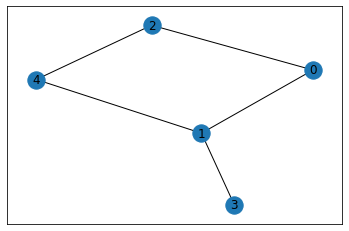

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    # first half:
    for k in range(n_qubits):
        layer.apply(RX(theta), k)
    
    # second half:
    for k, (i,j) in enumerate(edges):
        layer.apply(U_ZZ(beta), i , j)
    
    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement this part.

    for k in range(n_qubits):
        prog.apply(H, qubits[k])
        
    for l in range(n_layers):
        theta, beta = parameters[2*l], parameters[2*l+1]
        prog.apply(one_qaoa_layer(n_qubits, edges, theta, beta), qubits)
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        state_val = 0
        for i,j in edges:
            state_val +=  (1-2*int(sample.state.bitstring[i])) * (1-2*int(sample.state.bitstring[j]))
        obs += sample.probability * state_val
    # END TODO
    return obs
    
        

In [7]:
import numpy as np
np.random.random(3)

array([0.87113423, 0.02126664, 0.38767156])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:

1.7257160980912936 0.6784335452958499 -0.5517338414766423 -0.7294321809631017 -2.7161784440570633 -3.014479901303468 -3.509485716063661 -4.118682367007303 -4.190062962180375 -4.2068012468270135 -4.224726216261317 -4.257809615967048 -4.313720766398691 -4.362771838683294 -4.408003029128921 -4.468071238741418 -4.532688601717766 -4.604728930835885 -4.646843078586752 -4.652289281819598 -4.659653723558392 -4.660248157284326 -4.66129149187362 -4.662540955604925 -4.662589476928932 -4.662589579691785 -4.662589586922148 -4.662589588214759 -4.662589588287162 -1.8886320081503292 -2.7284965909965733 -2.8094749625537934 -3.3681771555574254 -3.5800189274139735 -3.795082400074597 -4.0032988011833455 -4.037367733411476 -4.085764203184898 -4.140562876420415 -4.167289323419566 -4.206052931427575 -4.262834803185265 -4.329448730197705 -4.340169091114529 -4.351053697790059 -4.363012259021869 -4.371923011828695 -4.374978919337142 -4.3791247773123265 -4.3827019173422945 -4.385805038580017 -4.388676123979213 -

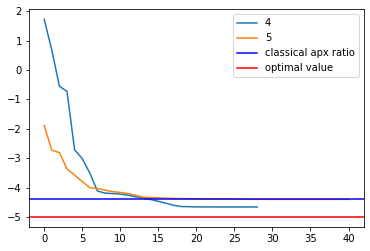

In [9]:
import matplotlib.pylab as plt


for nlayers in range(4,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()


### Question 6: smart initialization

-2.1359022554561484 -2.306776065464476 -2.3786302286584586 -2.9045333067443364 -2.9264881054511744 -3.099642484499871 -3.5940932070528433 -3.7466659352665554 -3.9225399327224832 -3.9731384756016843 -3.9774168125731735 -3.978216061979363 -3.9782679225184974 -3.9782690246237724 -3.9782690296436733 -3.978269029656433 -2.599981653802828 -3.365669937488377 -3.752963314097246 -3.927281721891532 -3.9688990528476964 -4.038229676942271 -4.103386074571563 -4.104857753078438 -4.10661798090159 -4.10953125918244 -4.114516849187229 -4.121888899534035 -4.135085308133915 -4.158063698065237 -4.1897058529735745 -4.2020498503168335 -4.2106212087023644 -4.215122577501769 -4.219179085284791 -4.224487825064949 -4.232017114759143 -4.234221082260475 -4.23433112679834 -4.234344703714801 -4.234345270256756 -4.234345296012444 -4.234345297607184 -4.234345297649698 -2.9000601975243523 -2.9620235020885404 -3.514442144393431 -3.833248912662027 -3.9183466252839443 -4.041166463547166 -4.085604340591704 -4.153148360741

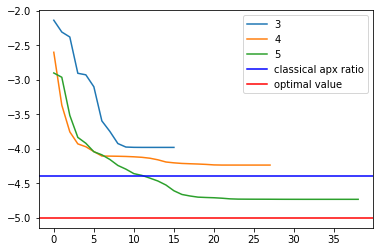

In [10]:
T = 1.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for l in range(nlayers):
        parameters_init.append(T*(1-l/float(nlayers)))
        parameters_init.append(T*l/float(nlayers))

        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()